In [1]:
# Vertex SDK for Python
! pip3 install --upgrade --quiet  google-cloud-aiplatform


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
PROJECT_ID = "mlops-sept25"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

In [3]:
BUCKET_URI = f"gs://mlops-sept25"  # @param {type:"string"}
BUCKET_NAME = "mlops-sept25"
MODEL_ARTIFACT_DIR="iris_classifier/model"

In [4]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://mlops-sept25/...
ServiceException: 409 A Cloud Storage bucket named 'mlops-sept25' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [5]:
DATA_V1 = f"gs://mlops-sept25/data/v1/data.csv"
DATA_V2 = f"gs://mlops-sept25/data/v2/data.csv" 

In [6]:
IRIS_DATA = f"gs://mlops-sept25/data/raw/iris.csv"

In [7]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

/opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


2025/11/16 16:32:53 INFO mlflow.tracking.fluent: Experiment with name 'iris-poisoning-logreg' does not exist. Creating a new experiment.



=== Running poison_0pct (feature) ===


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
2025/11/16 16:32:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 16:32:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logged poison_0pct: acc=0.950, f1=0.950

=== Running poison_5pct (feature) ===


2025/11/16 16:32:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 16:33:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logged poison_5pct: acc=0.933, f1=0.934

=== Running poison_10pct (feature) ===


2025/11/16 16:33:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 16:33:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logged poison_10pct: acc=0.850, f1=0.850

=== Running poison_50pct (feature) ===


2025/11/16 16:33:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 16:33:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged poison_50pct: acc=0.500, f1=0.495


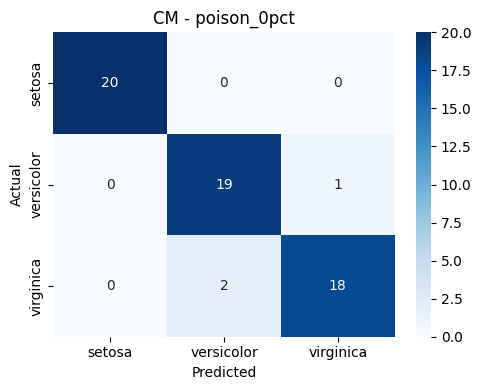

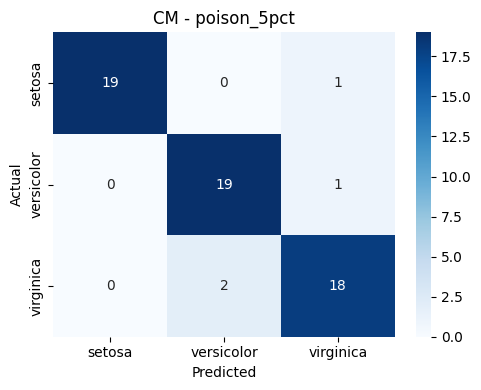

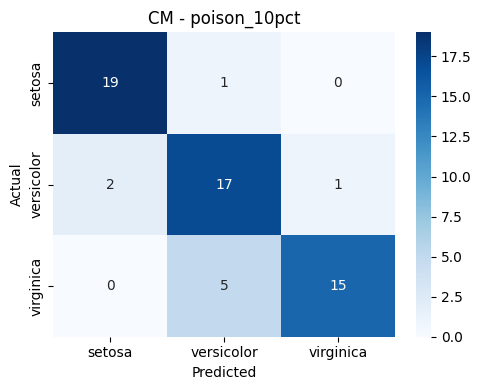

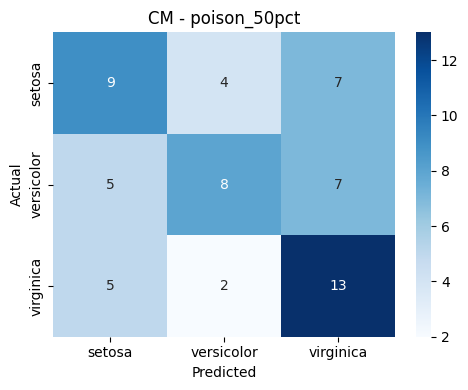

In [8]:
# Poisoning & MLflow logging with Logistic Regression
import os
import numpy as np
import pandas as pd
import mlflow, mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime

# --------------------------------
# CONFIG
# --------------------------------
MLFLOW_EXPERIMENT = "iris-poisoning-logreg"
mlflow.set_experiment(MLFLOW_EXPERIMENT)

CLEAN_DATA_PATH = IRIS_DATA
RANDOM_SEED = 42
POISON_LEVELS = [0.0, 0.05, 0.10, 0.50]
POISON_TYPE = "feature"   # "feature", "label", or "mixed"

np.random.seed(RANDOM_SEED)


# --------------------------------
# UTILITIES
# --------------------------------
def poison_data(df, contamination=0.05, poison_type="feature"):
    df = df.copy()
    n = len(df)
    k = int(np.floor(contamination * n))
    if k == 0:
        return df

    idx = np.random.choice(df.index, size=k, replace=False)

    # Feature poisoning = replace numeric features with random noise in valid ranges
    if poison_type in ["feature", "mixed"]:
        feat_cols = ['sepal_length','sepal_width','petal_length','petal_width']
        for c in feat_cols:
            low, high = df[c].min(), df[c].max()
            df.loc[idx, c] = np.random.uniform(low, high, k)

    # Label poisoning = flip labels randomly
    if poison_type in ["label", "mixed"]:
        classes = df['species'].unique()
        df.loc[idx, 'species'] = np.random.choice(classes, k)

    return df


def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    return fig


def run_training(df, run_label, model_params):
    X = df[['sepal_length','sepal_width','petal_length','petal_width']]
    y = df['species']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.4, random_state=RANDOM_SEED
    )

    clf = LogisticRegression(**model_params)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    report = classification_report(y_test, preds, output_dict=True)
    
    labels = np.unique(y)
    cm_fig = plot_confusion(y_test, preds, labels, title=f"CM - {run_label}")

    # Save model artifact
    ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    out_dir = f"artifacts/logreg/{run_label}-{ts}"
    os.makedirs(out_dir, exist_ok=True)

    model_path = f"{out_dir}/model.joblib"
    joblib.dump(clf, model_path)

    return {
        "acc": acc,
        "f1": f1,
        "report": report,
        "cm_fig": cm_fig,
        "model_path": model_path
    }


# --------------------------------
# MAIN EXPERIMENT LOOP
# --------------------------------

model_params = {
    "max_iter": 200,
    "multi_class": "auto",
    "solver": "lbfgs"
}

for contamination in POISON_LEVELS:
    label = f"poison_{int(contamination*100)}pct"

    df_clean = pd.read_csv(CLEAN_DATA_PATH)
    df_poisoned = poison_data(df_clean, contamination, POISON_TYPE)

    print(f"\n=== Running {label} ({POISON_TYPE}) ===")

    with mlflow.start_run(run_name=label):
        mlflow.log_param("poison_level", contamination)
        mlflow.log_param("poison_type", POISON_TYPE)
        mlflow.log_params(model_params)
        mlflow.log_param("model", "LogisticRegression")

        # Save sample of poisoned rows
        if contamination > 0:
            changed = (df_poisoned != df_clean).any(axis=1)
            sample = df_poisoned[changed].head(30)
            samp_path = f"artifacts/logreg/{label}-sample.csv"
            sample.to_csv(samp_path, index=False)
            mlflow.log_artifact(samp_path, artifact_path="poison-samples")

        result = run_training(df_poisoned, label, model_params)

        # Log metrics
        mlflow.log_metric("accuracy", result["acc"])
        mlflow.log_metric("f1_weighted", result["f1"])

        # Log classification report
        rep_df = pd.DataFrame(result["report"]).transpose()
        rep_path = f"artifacts/logreg/{label}-report.csv"
        rep_df.to_csv(rep_path)
        mlflow.log_artifact(rep_path, artifact_path="reports")

        # Log confusion matrix image
        cm_path = f"artifacts/logreg/{label}-cm.png"
        result["cm_fig"].savefig(cm_path)
        mlflow.log_artifact(cm_path, artifact_path="confusion_matrices")

        # Log model
        mlflow.sklearn.log_model(
            sk_model=joblib.load(result["model_path"]),
            artifact_path="model"
        )

        print(f"Logged {label}: acc={result['acc']:.3f}, f1={result['f1']:.3f}")
